 DAEDALUS – Distributed and Automated Evolutionary Deep Architecture Learning with Unprecedented Scalability

This research code was developed as part of the research programme Open Technology Programme with project number 18373, which was financed by the Dutch Research Council (NWO), Elekta, and Ortec Logiqcare.

Project leaders: Peter A.N. Bosman, Tanja Alderliesten
Researchers: Alex Chebykin, Arthur Guijt, Vangelis Kostoulas
Main code developer: Arthur Guijt

In [49]:
import polars as pl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import mannwhitneyu

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [50]:
processing_date = "2023-02-10"

In [51]:
%%R
library(tidyverse)
library(ggplot2)
library(ggh4x)

In [52]:
def relabel(df):
    # Relabeling
    # - Approach
    df["approach"] = "GA"
    df.loc[df["algorithm_type"].str.contains("ecga"), "approach"] = "ECGA"
    df.loc[df["algorithm_type"].str.contains("gomea"), "approach"] = "GOMEA"
    df.loc[df["algorithm_type"].str.contains("gomea"), "approach"] = "GOMEA"
    df.loc[(df["algorithm_type"].str.contains("gomea") & df["algorithm_type"].str.contains("immidiate")), "approach"] = "GOMEA-IMM"
    # df.loc[(df["algorithm_type"].str.contains("gomea") & df["algorithm_type"].str.contains("steady-state")), "approach"] = "SS-GOMEA"
    # df.loc[(df["algorithm_type"].str.contains("shuffled-fos")), "approach"] = df.loc[(df["algorithm_type"].str.contains("shuffled-fos")), "approach"] + "-SHUF"
    df["approach"] = pd.Categorical(df["approach"], categories=["GOMEA", "GOMEA-IMM", "ECGA", "GA"], ordered=True) # , "SS-GOMEA", "SS-GOMEA-SHUF"
    # - selection
    df["selection"] = "-"
    df.loc[df["replacement_strategy"] == 5, "selection"] = "steady-state"
    df.loc[df["replacement_strategy"] == 6, "selection"] = "generational"
    df["selection"] = pd.Categorical(df["selection"], categories=["-", "steady-state", "generational"], ordered=True)
    # - CX
    df["cx"] = "-"
    df.loc[df["algorithm_type"].str.contains("subfunction"), "cx"] = "SFX"
    df.loc[df["algorithm_type"].str.contains("uniform"), "cx"] = "UX"
    df.loc[df["algorithm_type"].str.contains("twopoint"), "cx"] = "TPX"
    df["cx"] = pd.Categorical(df["cx"], categories=["-", "UX", "TPX", "SFX"], ordered=True)
    # - (a)sync 
    df["(a)sync"] = "s"
    df.loc[df["algorithm_type"].str.contains("async"), "(a)sync"] = "a"
    df["(a)sync"] = pd.Categorical(df["(a)sync"], categories=["a", "s"], ordered=True)
    # - timing distribution - not saved for these plots
    # df["timing"] = pd.Categorical(df["runtime_type"].replace({
    #     "cheap-ones-100": "100:1",
    #     "cheap-ones-10": "10:1",
    #     "cheap-ones": "2:1",
    #     "constant": "1:1",
    #     "expensive-ones": "1:2",
    #     "expensive-ones-10": "1:10",
    #     "expensive-ones-100": "1:100",
    # }), categories = ["100:1", "10:1", "2:1", "1:1", "1:2", "1:10", "1:100"], ordered=True)

In [53]:
results = pd.concat([
    pd.read_csv("./results/2022-11-14-timing-ecga-nasbench_lim-8e78f7b-archive.csv.gz"),
    pd.read_csv("./results/2022-11-15-timing-ecga-nasbench-6_lim-30ae8d0-archive.csv.gz"),
    # pd.read_csv("./results/2022-11-14-timing-ga-nasbench_lim-8e78f7b-archive.csv.gz"), -- incorrect mutation
    pd.read_csv("./results/2022-11-22-timing-ga-nasbench_lim-292e8e5-archive.csv.gz"),
    pd.read_csv("./results/2022-11-14-timing-gomea-nasbench_lim-8e78f7b-archive.csv.gz"),
    # extra samples
    pd.read_csv("./results/2023-01-10-timing-ga-nasbench-ext_lim-49138ba-archive.csv.gz"),
    pd.read_csv("./results/2023-01-10-timing-ecga-nasbench-ext_lim-49138ba-archive.csv.gz"),
    pd.read_csv("./results/2023-01-10-timing-gomea-nasbench-ext_lim-49138ba-archive.csv.gz"),
    # -immidiate
    pd.read_csv("./results/2023-01-11-imm-gomea-nasbench-timing_lim-f418675-archive.csv.gz"),
    pd.read_csv("./results/2023-01-12-imm-gomea-nasbench-timing-extra_lim-aaffb5a-archive.csv.gz"),
    #
    # pd.read_csv("./results/2023-01-27-ss-gomea-nasbench-timing_lim-d4d7bed-archive.csv.gz"),
    # shuffled-fos-nasbench
    # pd.read_csv("./results/2023-01-30-ss-shuf-fos-gomea-nasbench-timing_lim-750c55f-archive.csv.gz"),
])

remapping_algorithm_type = {
    "sync": "ecga-sync",
    "async-throttled": "ecga-async-th",
}
results["algorithm_type"] = results["algorithm_type"].replace(remapping_algorithm_type)

vtr = results.iloc[0]["vtr"]

configuration_columns = ["replacement_strategy", "tournament_size", "algorithm_type"]
problem_columns = ["problem"]
run_columns = ["seed"]

In [54]:
results_hit = (results.
    sort_values("simulation time (s)").
    groupby(configuration_columns + problem_columns + run_columns).
    last().
    reset_index())

In [55]:
results_hit["configuration"] = ["_".join(str(rv) for rv in r[configuration_columns]) for _, r in results_hit.iterrows()]

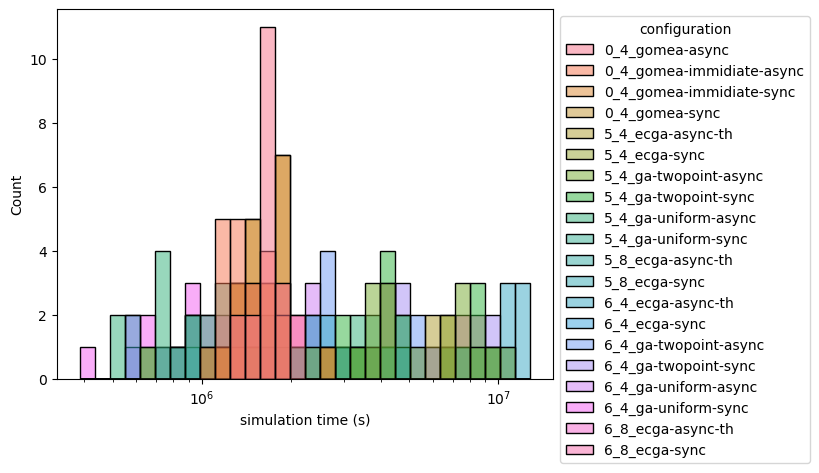

In [56]:
ax = sns.histplot(data=results_hit, x="simulation time (s)", hue="configuration", log_scale=(True, False), bins=30)
sns.move_legend(ax, bbox_to_anchor=(1,1), loc="upper left")

In [57]:
results_hit.groupby(configuration_columns)["simulation time (s)"].count().rename("successes").reset_index().style

,replacement_strategy,tournament_size,algorithm_type,successes
0,0,4,gomea-async,20
1,0,4,gomea-immidiate-async,20
2,0,4,gomea-immidiate-sync,20
3,0,4,gomea-sync,20
4,5,4,ecga-async-th,5
5,5,4,ecga-sync,0
6,5,4,ga-twopoint-async,20
7,5,4,ga-twopoint-sync,17
8,5,4,ga-uniform-async,20
9,5,4,ga-uniform-sync,20


In [58]:
tab = results_hit.groupby(configuration_columns)["simulation time (s)"].median().reset_index().style.format(na_rep="-", precision=0)
# tab.to_excel("results-nasbench-timing.xlsx")
tab

,replacement_strategy,tournament_size,algorithm_type,simulation time (s)
0,0,4,gomea-async,1677091
1,0,4,gomea-immidiate-async,1361821
2,0,4,gomea-immidiate-sync,1652285
3,0,4,gomea-sync,1652285
4,5,4,ecga-async-th,6337024
5,5,4,ecga-sync,-
6,5,4,ga-twopoint-async,4258886
7,5,4,ga-twopoint-sync,4328658
8,5,4,ga-uniform-async,982413
9,5,4,ga-uniform-sync,1400998


In [10]:
tab_ss = results_hit.groupby(configuration_columns)["simulation time (s)"].median()
tab_ss = (tab_ss / 10**6).rename("simulation time (s) × 10^6")
tab_ss

replacement_strategy  tournament_size  algorithm_type       
0                     4                gomea-async              1.677091
                                       gomea-immidiate-async    1.361821
                                       gomea-immidiate-sync     1.652285
                                       gomea-sync               1.652285
5                     4                ecga-async-th            6.337024
                                       ecga-sync                     NaN
                                       ga-twopoint-async        4.258886
                                       ga-twopoint-sync         4.328658
                                       ga-uniform-async         0.982413
                                       ga-uniform-sync          1.400998
                      8                ecga-async-th            7.135425
                                       ecga-sync                     NaN
6                     4                ecga-async-th           

In [11]:
tab_ps = results_hit.groupby(configuration_columns)["population_size"].median().rename("population size")
tab_ps

replacement_strategy  tournament_size  algorithm_type       
0                     4                gomea-async                49.5
                                       gomea-immidiate-async      63.5
                                       gomea-immidiate-sync       58.5
                                       gomea-sync                 58.5
5                     4                ecga-async-th            4096.0
                                       ecga-sync                   NaN
                                       ga-twopoint-async        1024.0
                                       ga-twopoint-sync         1024.0
                                       ga-uniform-async          252.5
                                       ga-uniform-sync           368.5
                      8                ecga-async-th            4096.0
                                       ecga-sync                   NaN
6                     4                ecga-async-th            2048.0
                

In [12]:
tab_c = pd.concat([tab_ps, tab_ss], axis=1).style.format({"population size": "{:0.1f}", "simulation time (s) × 10^6": "{:0.2f}"}, na_rep="-")
# tab_c.to_excel(f"{processing_date}-results-nasbench-timed.xlsx")
tab_c

In [13]:
results_hit["simulation time (s) × 10^6"] = results_hit["simulation time (s)"] / 10**6
results_hit.loc[~np.isfinite(results_hit["simulation time (s) × 10^6"]), "simulation time (s) × 10^6"] = np.inf
tab_sts = results_hit.groupby(configuration_columns)["simulation time (s) × 10^6"].quantile([0.1, 0.3, 0.5, 0.7, 0.9]).unstack()
tab_sts

0.1  \
replacement_strategy tournament_size algorithm_type                    
0                    4               gomea-async            1.500776   
                                     gomea-immidiate-async  1.134198   
                                     gomea-immidiate-sync   1.358407   
                                     gomea-sync             1.358407   
5                    4               ecga-async-th          6.324659   
                                     ecga-sync                   NaN   
                                     ga-twopoint-async      2.253171   
                                     ga-twopoint-sync       2.777966   
                                     ga-uniform-async       0.657142   
                                     ga-uniform-sync        0.908130   
                     8               ecga-async-th               inf   
                                     ecga-sync                   NaN   
6                    4               ecga-async-th          1.690558   
                                     ecga-sync                   NaN   
                                     ga-twopoint-async      2.053053   
                                     ga-twopoint-sync       1.459122   
                                     ga-uniform-async       0.939199   
                                     ga-uniform-sync        0.583463   
                     8               ecga-async-th          2.675867   
                                     ecga-sync                   inf   

                                                                 0.3  \
replacement_strategy tournament_size algorithm_type                    
0                    4               gomea-async            1.613160   
                                     gomea-immidiate-async  1.275085   
                                     gomea-immidiate-sync   1.491985   
                                     gomea-sync             1.491985   
5                    4               ecga-async-th               NaN   
                                     ecga-sync                   NaN   
                                     ga-twopoint-async      3.784779   
                                     ga-twopoint-sync       4.105908   
                                     ga-uniform-async       0.766672   
                                     ga-uniform-sync        1.173367   
                     8               ecga-async-th               NaN   
                                     ecga-sync                   NaN   
6                    4               ecga-async-th          2.692523   
                                     ecga-sync                   NaN   
                                     ga-twopoint-async      2.652899   
                                     ga-twopoint-sync       3.206610   
                                     ga-uniform-async       1.255117   
                                     ga-uniform-sync        0.811012   
                     8               ecga-async-th          3.555997   
                                     ecga-sync                   NaN   

                                                                 0.5  \
replacement_strategy tournament_size algorithm_type                    
0                    4               gomea-async            1.677091   
                                     gomea-immidiate-async  1.361821   
                                     gomea-immidiate-sync   1.652285   
                                     gomea-sync             1.652285   
5                    4               ecga-async-th               NaN   
                                     ecga-sync                   NaN   
                                     ga-twopoint-async      4.258886   
                                     ga-twopoint-sync       4.492289   
                                     ga-uniform-async       0.982413   
                                     ga-uniform-sync        1.400998   
                     8         

In [14]:
results_hit["simulation time (s) × 10^6"] = results_hit["simulation time (s)"] / 10**6
results_hit["success"] = np.isfinite(results_hit["simulation time (s) × 10^6"])
tab_sts = results_hit.groupby(configuration_columns)["success"].sum()
tab_sts

replacement_strategy  tournament_size  algorithm_type       
0                     4                gomea-async              20
                                       gomea-immidiate-async    20
                                       gomea-immidiate-sync     20
                                       gomea-sync               20
5                     4                ecga-async-th             5
                                       ecga-sync                 0
                                       ga-twopoint-async        20
                                       ga-twopoint-sync         17
                                       ga-uniform-async         20
                                       ga-uniform-sync          20
                      8                ecga-async-th             1
                                       ecga-sync                 0
6                     4                ecga-async-th            16
                                       ecga-sync                 1
 

In [15]:
rh = results_hit.copy()
relabel(rh)
rh["population_size"] = np.where(np.isfinite(rh["population_size"]), rh["population_size"], np.inf)
rh["simulation time (s)"] = np.where(np.isfinite(rh["simulation time (s)"]), rh["simulation time (s)"], np.inf)
rh["simulation time (s) × 10^6"] = np.where(np.isfinite(rh["simulation time (s) × 10^6"]), rh["simulation time (s) × 10^6"], np.inf)

rh

,replacement_strategy,tournament_size,algorithm_type,problem,seed,Unnamed: 0,#evaluations,simulation time (s),objectives,archive ordinal,...,vtr,num_processors,population_size,configuration,simulation time (s) × 10^6,success,approach,selection,cx,(a)sync
0,0,4,gomea-async,nasbench301,42,35,21034.0,1.893608e+06,-95.2776,36.0,...,95.2726,64,116.0,0_4_gomea-async,1.893608,True,GOMEA,-,-,a
1,0,4,gomea-async,nasbench301,43,40,4304.0,1.652984e+06,-95.2834,41.0,...,95.2726,64,15.0,0_4_gomea-async,1.652984,True,GOMEA,-,-,a
2,0,4,gomea-async,nasbench301,44,29,19291.0,1.702465e+06,-95.2727,30.0,...,95.2726,64,97.0,0_4_gomea-async,1.702465,True,GOMEA,-,-,a
3,0,4,gomea-async,nasbench301,45,33,15268.0,1.336429e+06,-95.2764,34.0,...,95.2726,64,64.0,0_4_gomea-async,1.336429,True,GOMEA,-,-,a
4,0,4,gomea-async,nasbench301,46,40,13710.0,2.117766e+06,-95.2727,41.0,...,95.2726,64,38.0,0_4_gomea-async,2.117766,True,GOMEA,-,-,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,6,8,ecga-sync,nasbench301,47,0,NaN,inf,NaN,NaN,...,95.2726,64,inf,6_8_ecga-sync,inf,False,ECGA,generational,-,s
356,6,8,ecga-sync,nasbench301,48,30,41844.0,3.617037e+06,-95.2763,31.0,...,95.2726,64,4096.0,6_8_ecga-sync,3.617037,True,ECGA,generational,-,s
357,6,8,ecga-sync,nasbench301,49,0,NaN,inf,NaN,NaN,...,95.2726,64,inf,6_8_ecga-sync,inf,False,ECGA,generational,-,s
358,6,8,ecga-sync,nasbench301,50,0,NaN,inf,NaN,NaN,...,95.2726,64,inf,6_8_ecga-sync,inf,False,ECGA,generational,-,s


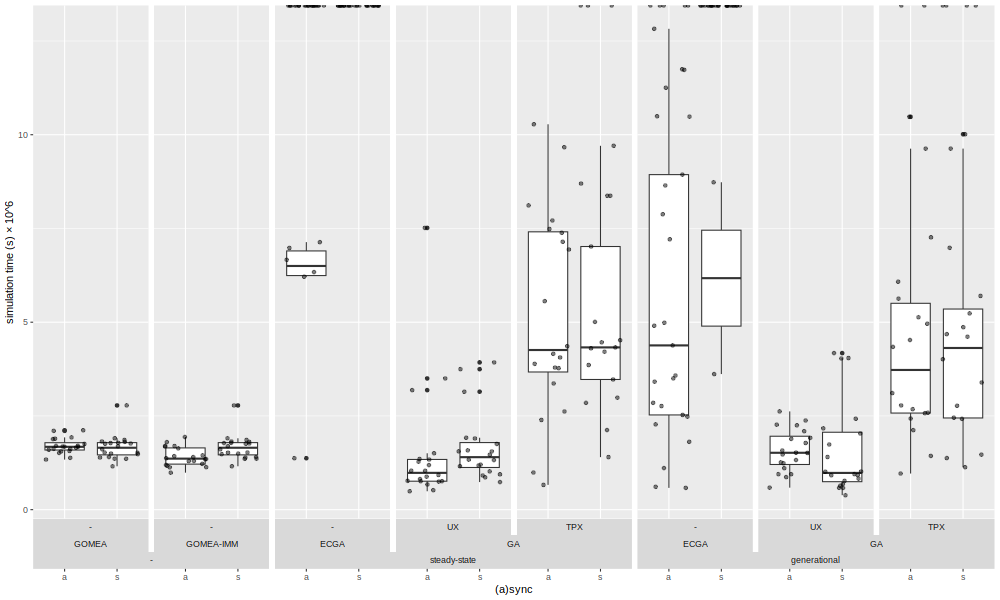

In [16]:
%%R -i rh -w 1000 -h 600

rh |>
    ggplot(aes(x=`(a)sync`, y=`simulation time (s) × 10^6`)) +
    facet_grid2(. ~ `selection` + `approach` + `cx`, strip = strip_nested(), switch="x") +
    geom_boxplot() +
    geom_point(position = position_jitter(), alpha=0.5)


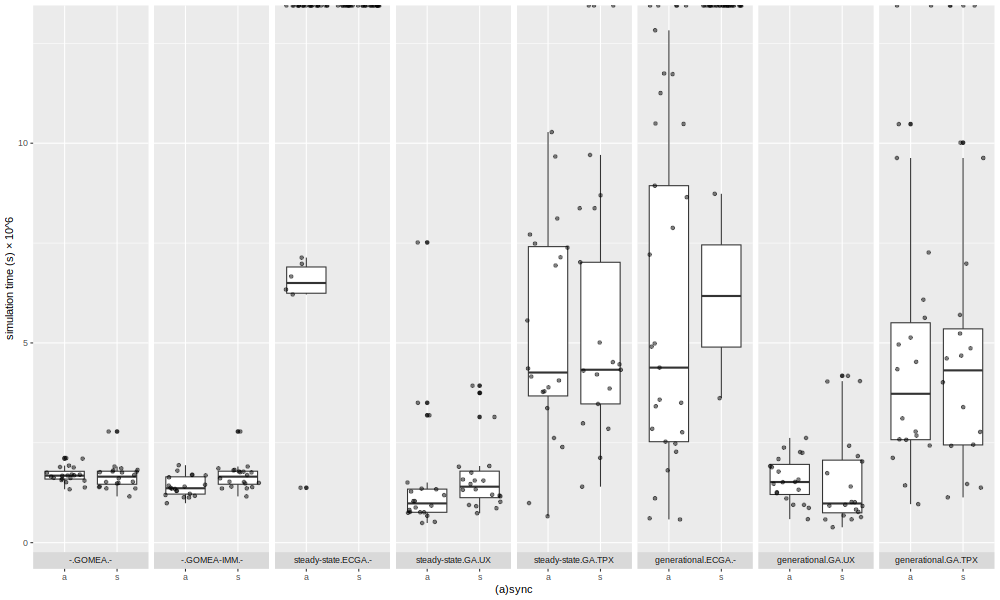

In [17]:
%%R -i rh -w 1000 -h 600

rh |>
    ggplot(aes(x=`(a)sync`, y=`simulation time (s) × 10^6`)) +
    facet_grid2(. ~ weave_factors(`selection`, `approach`, `cx`), strip = strip_nested(), switch="x") +
    geom_boxplot() +
    geom_point(position = position_jitter(), alpha=0.5)


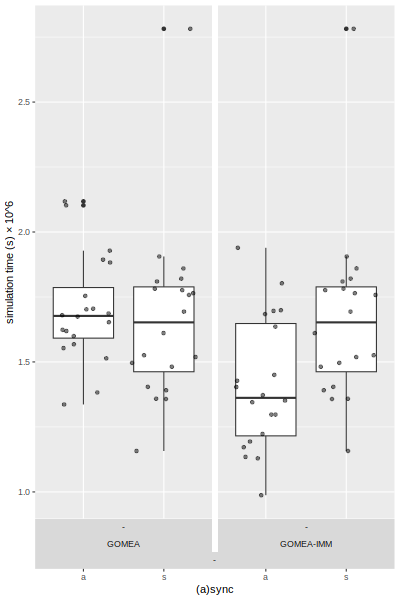

In [18]:
%%R -i rh -w 400 -h 600

rh |> 
filter(`approach` == "GOMEA" | `approach` == "GOMEA-IMM") |>
    ggplot(aes(x=`(a)sync`, y=`simulation time (s) × 10^6`)) +
    facet_grid2(. ~ `selection` + `approach` + `cx`, strip = strip_nested(), switch="x") +
    geom_boxplot() +
    geom_point(position = position_jitter(), alpha=0.5)


In [74]:
results_hit["simulation time (s) × 10^6"] = results_hit["simulation time (s)"] / 10**6
results_hit.loc[~np.isfinite(results_hit["population_size"]), "population_size"] = np.inf
results_hit.loc[~np.isfinite(results_hit["simulation time (s) × 10^6"]), "simulation time (s) × 10^6"] = np.inf
relabel(results_hit)
results_hit_ss = results_hit[results_hit["tournament_size"] == 4]
tab_sts = results_hit_ss.groupby(["selection", "approach", "cx", "(a)sync"], observed=True).agg({
    "population_size": ['median', 'count'],
    "simulation time (s) × 10^6": ['median'],
})
tab_sts.T.to_excel(f"{processing_date}-nasbench.xlsx")

In [75]:
tab_sts

population_size        \
                                            median count   
selection    approach  cx  (a)sync                         
-            GOMEA     -   a                  49.5    20   
                           s                  58.5    20   
             GOMEA-IMM -   a                  63.5    20   
                           s                  58.5    20   
steady-state ECGA      -   a                   inf    20   
                           s                   inf    20   
             GA        UX  a                 252.5    20   
                           s                 368.5    20   
                       TPX a                1024.0    20   
                           s                1110.0    20   
generational ECGA      -   a                3072.0    20   
                           s                   inf    20   
             GA        UX  a                 816.0    20   
                           s                 480.5    20   
                       TPX a                2048.0    20   
                           s                2048.0    20   

                                   simulation time (s) × 10^6  
                                                       median  
selection    approach  cx  (a)sync                             
-            GOMEA     -   a                         1.677091  
                           s                         1.652285  
             GOMEA-IMM -   a                         1.361821  
                           s                         1.652285  
steady-state ECGA      -   a                              inf  
                           s                              inf  
             GA        UX  a                         0.982413  
                           s                         1.400998  
                       TPX a                         4.258886  
                           s                         4.492289  
generational ECGA      -   a                         7.734439  
                           s                              inf  
             GA        UX  a                         1.517906  
                           s                         0.980716  
                       TPX a                         4.434104  
                           s                         4.774914

In [76]:
tab_sim_quant = results_hit_ss.groupby(["selection", "approach", "cx", "(a)sync"], observed=True)["simulation time (s) × 10^6"].quantile([0.25, 0.5, 0.75]).unstack()


In [77]:
tab_pop_quant = results_hit_ss.groupby(["selection", "approach", "cx", "(a)sync"], observed=True)["population_size"].quantile([0.25, 0.5, 0.75]).unstack()

In [78]:
results_hit_ss

,replacement_strategy,tournament_size,algorithm_type,problem,seed,Unnamed: 0,#evaluations,simulation time (s),objectives,archive ordinal,...,genotype (categorical),vtr,num_processors,population_size,configuration,simulation time (s) × 10^6,approach,selection,cx,(a)sync
0,0,4,gomea-async,nasbench301,42,35,21034.0,1.893608e+06,-95.2776,36.0,...,2 2 0 4 2 1 2 0 4 0 4 6 4 5 2 3 3 3 3 4 3 3 0 ...,95.2726,64,116.0,0_4_gomea-async,1.893608,GOMEA,-,-,a
1,0,4,gomea-async,nasbench301,43,40,4304.0,1.652984e+06,-95.2834,41.0,...,2 2 3 4 2 1 2 0 4 0 0 4 4 4 2 3 3 3 2 4 4 3 4 ...,95.2726,64,15.0,0_4_gomea-async,1.652984,GOMEA,-,-,a
2,0,4,gomea-async,nasbench301,44,29,19291.0,1.702465e+06,-95.2727,30.0,...,2 2 0 4 2 1 1 0 4 0 0 3 3 2 2 3 4 3 3 3 4 3 4 ...,95.2726,64,97.0,0_4_gomea-async,1.702465,GOMEA,-,-,a
3,0,4,gomea-async,nasbench301,45,33,15268.0,1.336429e+06,-95.2764,34.0,...,2 2 4 4 2 1 2 0 4 0 4 4 4 2 3 3 4 3 3 3 4 3 3 ...,95.2726,64,64.0,0_4_gomea-async,1.336429,GOMEA,-,-,a
4,0,4,gomea-async,nasbench301,46,40,13710.0,2.117766e+06,-95.2727,41.0,...,2 2 0 4 2 1 1 0 4 0 3 3 5 0 4 3 4 3 3 3 4 3 4 ...,95.2726,64,38.0,0_4_gomea-async,2.117766,GOMEA,-,-,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,6,4,ga-uniform-sync,nasbench301,57,42,22437.0,2.031382e+06,-95.2769,43.0,...,2 2 3 4 2 1 2 0 4 0 3 3 4 3 3 3 4 3 3 3 5 3 4 ...,95.2726,64,1138.0,6_4_ga-uniform-sync,2.031382,GA,generational,UX,s
336,6,4,ga-uniform-sync,nasbench301,58,34,10249.0,9.491549e+05,-95.2727,35.0,...,2 2 0 4 2 1 1 0 4 0 3 3 1 4 5 3 4 3 3 3 3 3 4 ...,95.2726,64,447.0,6_4_ga-uniform-sync,0.949155,GA,generational,UX,s
337,6,4,ga-uniform-sync,nasbench301,59,37,9809.0,9.184625e+05,-95.2727,38.0,...,2 2 0 4 2 1 1 0 4 0 3 3 4 1 4 3 4 3 4 3 4 3 4 ...,95.2726,64,480.0,6_4_ga-uniform-sync,0.918463,GA,generational,UX,s
338,6,4,ga-uniform-sync,nasbench301,60,35,3950.0,3.859135e+05,-95.2834,36.0,...,2 2 3 4 2 1 2 0 4 0 4 5 4 6 2 3 3 3 3 4 3 3 4 ...,95.2726,64,128.0,6_4_ga-uniform-sync,0.385914,GA,generational,UX,s


In [79]:
results_hit_ss = results_hit[results_hit["tournament_size"] == 4].copy() # removed groupby "tournament_size"
results_hit_ss = results_hit_ss[(results_hit_ss["approach"] != "GOMEA-IMM") | (results_hit_ss["(a)sync"] != "s")]
str_c = results_hit_ss["(a)sync"].astype(str)
str_c[(results_hit_ss["approach"] == "GOMEA-IMM") & (results_hit_ss["(a)sync"] == "a")] = "a/i"
str_c[(results_hit_ss["approach"] == "GOMEA") & (results_hit_ss["(a)sync"] == "a")] = "a/e"
results_hit_ss["(a)sync"] = pd.Categorical(str_c, ["a", "a/e", "a/i", "s"], ordered=True)
results_hit_ss["approach"] = results_hit_ss["approach"].replace({"GOMEA-IMM": "GOMEA"})

results_hit_ss["simulation time (s) × 10^6"] = np.where(np.isfinite(results_hit_ss["simulation time (s) × 10^6"]), results_hit_ss["simulation time (s) × 10^6"], np.inf)
results_hit_ss["population_size"] = np.where(np.isfinite(results_hit_ss["population_size"]), results_hit_ss["population_size"], np.inf)
tab_sts = results_hit_ss.groupby(["selection", "approach", "cx", "(a)sync"], observed=True).agg({
    "simulation time (s) × 10^6": [lambda x: x.quantile(0.25), lambda x: x.quantile(0.5), lambda x: x.quantile(0.75)],
    "population_size": [lambda x: x.quantile(0.25), lambda x: x.quantile(0.5), lambda x: x.quantile(0.75)],
})
tab_sts = tab_sts.replace({np.inf: np.nan}).style.format(na_rep='-')
tab_sts.to_excel(f"{processing_date}-nasbench-extended.xlsx")
tab_sts

/home/arthur/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4489: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5)
/home/arthur/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [80]:
# results_hit_ss = results_hit#[results_hit["tournament_size"] == 4]
# tab_sts = results_hit_ss.groupby(["selection", "approach", "cx", "(a)sync", "tournament_size"], observed=True).agg({
#     "population_size": [lambda x: x.quantile(0.1), lambda x: x.quantile(0.3), lambda x: x.quantile(0.5), lambda x: x.quantile(0.7), lambda x: x.quantile(0.9)],
#     "simulation time (s) × 10^6": [lambda x: x.quantile(0.1), lambda x: x.quantile(0.3), lambda x: x.quantile(0.5), lambda x: x.quantile(0.7), lambda x: x.quantile(0.9)],
# })
# tab_sts.replace({np.inf: np.nan}).style.format(na_rep='-')

In [81]:
tab_sts = results_hit_ss.groupby(["selection", "approach", "cx", "(a)sync", "tournament_size"], observed=True)["success"].sum()
tab_sts.reset_index().style

KeyError: 'Column not found: success'

In [82]:
grouped = results_hit_ss.\
    groupby(["selection", "approach", "cx", "(a)sync", "tournament_size"], observed=True)["simulation time (s) × 10^6"].\
    apply(list).\
    reset_index()
grouped_cross = pd.merge(grouped, grouped, how='cross')
grouped_cross[["U", "p"]] = grouped_cross.apply(lambda x: pd.Series(mannwhitneyu(x["simulation time (s) × 10^6_x"], x["simulation time (s) × 10^6_y"])), axis=1)
grouped_cross

,selection_x,approach_x,cx_x,(a)sync_x,tournament_size_x,simulation time (s) × 10^6_x,selection_y,approach_y,cx_y,(a)sync_y,tournament_size_y,simulation time (s) × 10^6_y,U,p
0,-,GOMEA,-,a/e,4,"[1.89360789965, 1.652984001128, 1.702465013508...",-,GOMEA,-,a/e,4,"[1.89360789965, 1.652984001128, 1.702465013508...",200.0,1.000000e+00
1,-,GOMEA,-,a/e,4,"[1.89360789965, 1.652984001128, 1.702465013508...",-,GOMEA,-,a/i,4,"[1.939217375852, 1.3511785311439999, 1.1718658...",315.0,1.953348e-03
2,-,GOMEA,-,a/e,4,"[1.89360789965, 1.652984001128, 1.702465013508...",-,GOMEA,-,s,4,"[1.157486203521, 1.481660991711, 1.75778354791...",224.0,5.249869e-01
3,-,GOMEA,-,a/e,4,"[1.89360789965, 1.652984001128, 1.702465013508...",steady-state,ECGA,-,a,4,"[6.337024461524001, inf, inf, inf, 6.663727230...",19.0,5.273838e-07
4,-,GOMEA,-,a/e,4,"[1.89360789965, 1.652984001128, 1.702465013508...",steady-state,ECGA,-,s,4,"[inf, inf, inf, inf, inf, inf, inf, inf, inf, ...",0.0,8.006545e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,generational,GA,TPX,s,4,"[5.23522032034, 2.454141528544, 6.984301254747...",generational,ECGA,-,s,4,"[inf, inf, inf, inf, inf, inf, inf, inf, inf, ...",44.0,2.964338e-06
221,generational,GA,TPX,s,4,"[5.23522032034, 2.454141528544, 6.984301254747...",generational,GA,UX,a,4,"[2.267635994348, 2.2497090735570002, 1.2386238...",359.0,1.791149e-05
222,generational,GA,TPX,s,4,"[5.23522032034, 2.454141528544, 6.984301254747...",generational,GA,UX,s,4,"[0.769081267204, 1.012277881198, 4.04378713044...",361.0,1.401813e-05
223,generational,GA,TPX,s,4,"[5.23522032034, 2.454141528544, 6.984301254747...",generational,GA,TPX,a,4,"[2.781412506573, 3.11114474803, 10.47834636704...",221.0,5.785941e-01


In [84]:
gcpt = grouped_cross.pivot_table(index=["selection_x", "approach_x", "cx_x", "(a)sync_x"], columns=["selection_y", "approach_y", "cx_y", "(a)sync_y"], values=["U", "p"])

p = 0.05
def mark_significance_row(x):
    x = x["p"]
    # x is a row
    o = np.argsort(x)
    o_inv = np.argsort(o)
    # test against 1/i - though in this case one of the samples is
    # ourselves - exclude that from the count.
    rcs = np.concatenate([np.flip(np.arange(len(x) - 1) + 1), [1]])
    ps = p / rcs
    s = x[o] < ps
    s = np.cumsum(s) == np.arange(len(x)) + 1
    r = np.where(s[o_inv], "color: red", "")
    return np.concatenate([r, r])

gcpt_s = gcpt.style
gcpt_s.apply(mark_significance_row, axis=1)
gcpt_s.to_excel(f"{processing_date}-stattest.xlsx")
gcpt_s